In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')


In [4]:

from IPython.display import HTML, Image

## Review of GPU Architechture - A Simplification

### Memory

GPUs or GPGPUs are complex devices, but to get started, one really just needs to understand a more simplistic view.

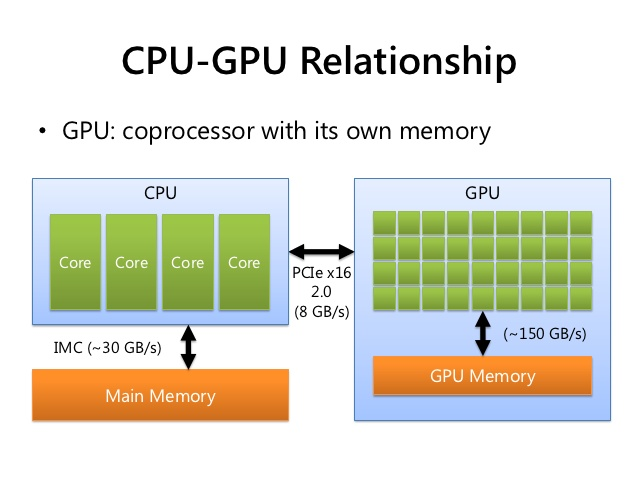

In [12]:
Image ('./GPUCPUOverview.jpg')

The most important thing to understand about memory, is that the CPU can access both main memory (host) and GPU memory (device).  The device sees only its memory, and cannot access the host memory.

### Kernels, Threads and Blocks

Recall that GPUs are SIMD.  This means that each CUDA core gets the same code, called a 'kernel'.  Kernels are programmed to execute one 'thread' (execution unit or task).  The 'trick' is that each thread 'knows' its identity, in the form of a grid location, and is usually coded to access an array of data at a unique location for the thread.  

We will concentrate on a 1-dimensional grid with each thread in a block by itself, but let's understand when we might want to organize threads into blocks.


GPU memory can be expanded (roughly) into 3 types:

* local - memory only seen by the thread. This is the fastest type
* shared - memory that may be seen by all threads in a block.  Fast memory, but not as fast as local.
* global - memory seen by all threads in all blocks.  This is the slowest to access.

So, if multiple threads need to use the *same* data (not unique chunks of an array, but the very same data), then those threads should be grouped into a common block, and the data should be stored in shared memory.



### Cuda C program - an Outline

The following are the minimal ingredients for a Cuda C program:

* The kernel.  This is the function that will be executed in parallel on the GPU.


* Main C program
  - allocates memory on the GPU
  - copies data in CPU memory to GPU memory
  - 'launches' the kernel (just a function call with some extra arguments)
  - copies data from GPU memory back to CPU memory

### Kernel Code

In [13]:
%%file kernel.hold

__global void square_kernel(float *d_out, float *d_in){
  
  int i = thread.Idx;   # This is a unique identifier of the thread   
  float f = d_in[i]     # Why this statement?
  d_out[i] = f*f;       # d_out is what we will copy back to the host memory

}

Writing kernel.hold


### CPU Code

In [14]:
%%file main.hold

int main(int argc, char **argv){
const int ARRAY_SIZE = 64;
    const int ARRAY_BYTES = ARRAY_SIZE * sizeof(float);

    float h_in[ARRAY_SIZE];

    for (int i =0;i<ARRAY_SIZE;i++){
        h_in[i] = float(i);
    } float h_out[ARRAY_SIZE];

    float *d_in;  // These are device memory pointers
    float *d_out;

    cudaMalloc((void **) &d_in, ARRAY_BYTES);
    cudaMalloc((void **) &d_out, ARRAY_BYTES);
      
    cudaMemcpy(d_in, h_in, ARRAY_BYTES,cudaMemcpyHostToDevice);

    square_kernel<<<1,ARRAY_SIZE>>>(d_out,d_in);

    cudaMemcpy(h_out,d_out,ARRAY_BYTES,cudaMemcpyDeviceToHost);

    for (int i = 0;i<ARRAY_SIZE;i++){
        printf("%f", h_out[i]);
        printf(((i % 4) != 3 ? "\t" : "\n"));
    }
   
    cudaFree(d_in);



}

Writing shared_mem_example.cu


### Shared Memory

Lifted from: https://www.cac.cornell.edu/vw/gpu/shared_mem_exec.aspx

In [15]:
%%file shared_mem_ex.cu

#include <stdio.h>
#include <stdlib.h>

#define N 1024*1024
#define BLOCKSIZE 1024

__global__ 
void share_ary_oper(int *ary, int *ary_out)
{
    // Thread index
        int tx = threadIdx.x;
        int idx=blockDim.x*blockIdx.x + threadIdx.x;
        __shared__ int part_ary[BLOCKSIZE];

        part_ary[tx]=ary[idx];
        part_ary[tx]=part_ary[tx]*10;
        ary_out[idx]=part_ary[tx];
        __syncthreads();
}

int main(){

        int *device_array, *device_array_out;
        int *host_array, *host_array_out;
        int i, nblk;
        float k;
        size_t size = N*sizeof(int);

//Device memory
        cudaMalloc((void **)&device_array, size);
        cudaMalloc((void **)&device_array_out, size);
//Host memory
//cudaMallocHost() produces pinned memoty on the host
        cudaMallocHost((void **)&host_array, size);
        cudaMallocHost((void **)&host_array_out, size);

        for(i=0;i<N;i++)
        {
                host_array[i]=i;
                host_array_out[i]=0;
        }
        cudaMemcpy(device_array, host_array, size, cudaMemcpyHostToDevice);
        cudaMemcpy(device_array_out, host_array_out, size, cudaMemcpyHostToDevice);
        nblk=N/BLOCKSIZE;
        share_ary_oper<<<nblk, BLOCKSIZE>>>(device_array, device_array_out);
        cudaMemcpy(host_array, device_array, size, cudaMemcpyDeviceToHost);
        cudaMemcpy(host_array_out, device_array_out, size, cudaMemcpyDeviceToHost);


	printf("Printing elements 10-15 of output array\n");
        for (i=N;i<N;i++)
        {
                k=host_array_out[i]-i*10;    
                if(k<0.1)
                        printf("Incorrect IX %d=%.1f\n",i, k);
        }
        for (i=10;i<15;i++)
                printf("host_array_out[%d]=%d\n", i, host_array_out[i]);

        cudaFree(device_array);
        cudaFree(host_array);
        cudaFree(device_array_out);
        cudaFree(host_array_out);
        cudaDeviceReset();
        return EXIT_SUCCESS;
}

Writing shared_mem_ex.cu


##### Makefile

In [20]:
%%file Makefile

CC=nvcc
CFLAGS=-Wall

shared_mem.o: shared_mem_ex.cu
	 $(CC) $(CFAGS) -c shared_mem_ex.cu

clean:
	 rm -f *.o

Overwriting Makefile


##### Compile

In [21]:
! make 

nvcc  -c shared_mem_ex.cu
make: nvcc: Command not found
make: *** [shared_mem.o] Error 127
